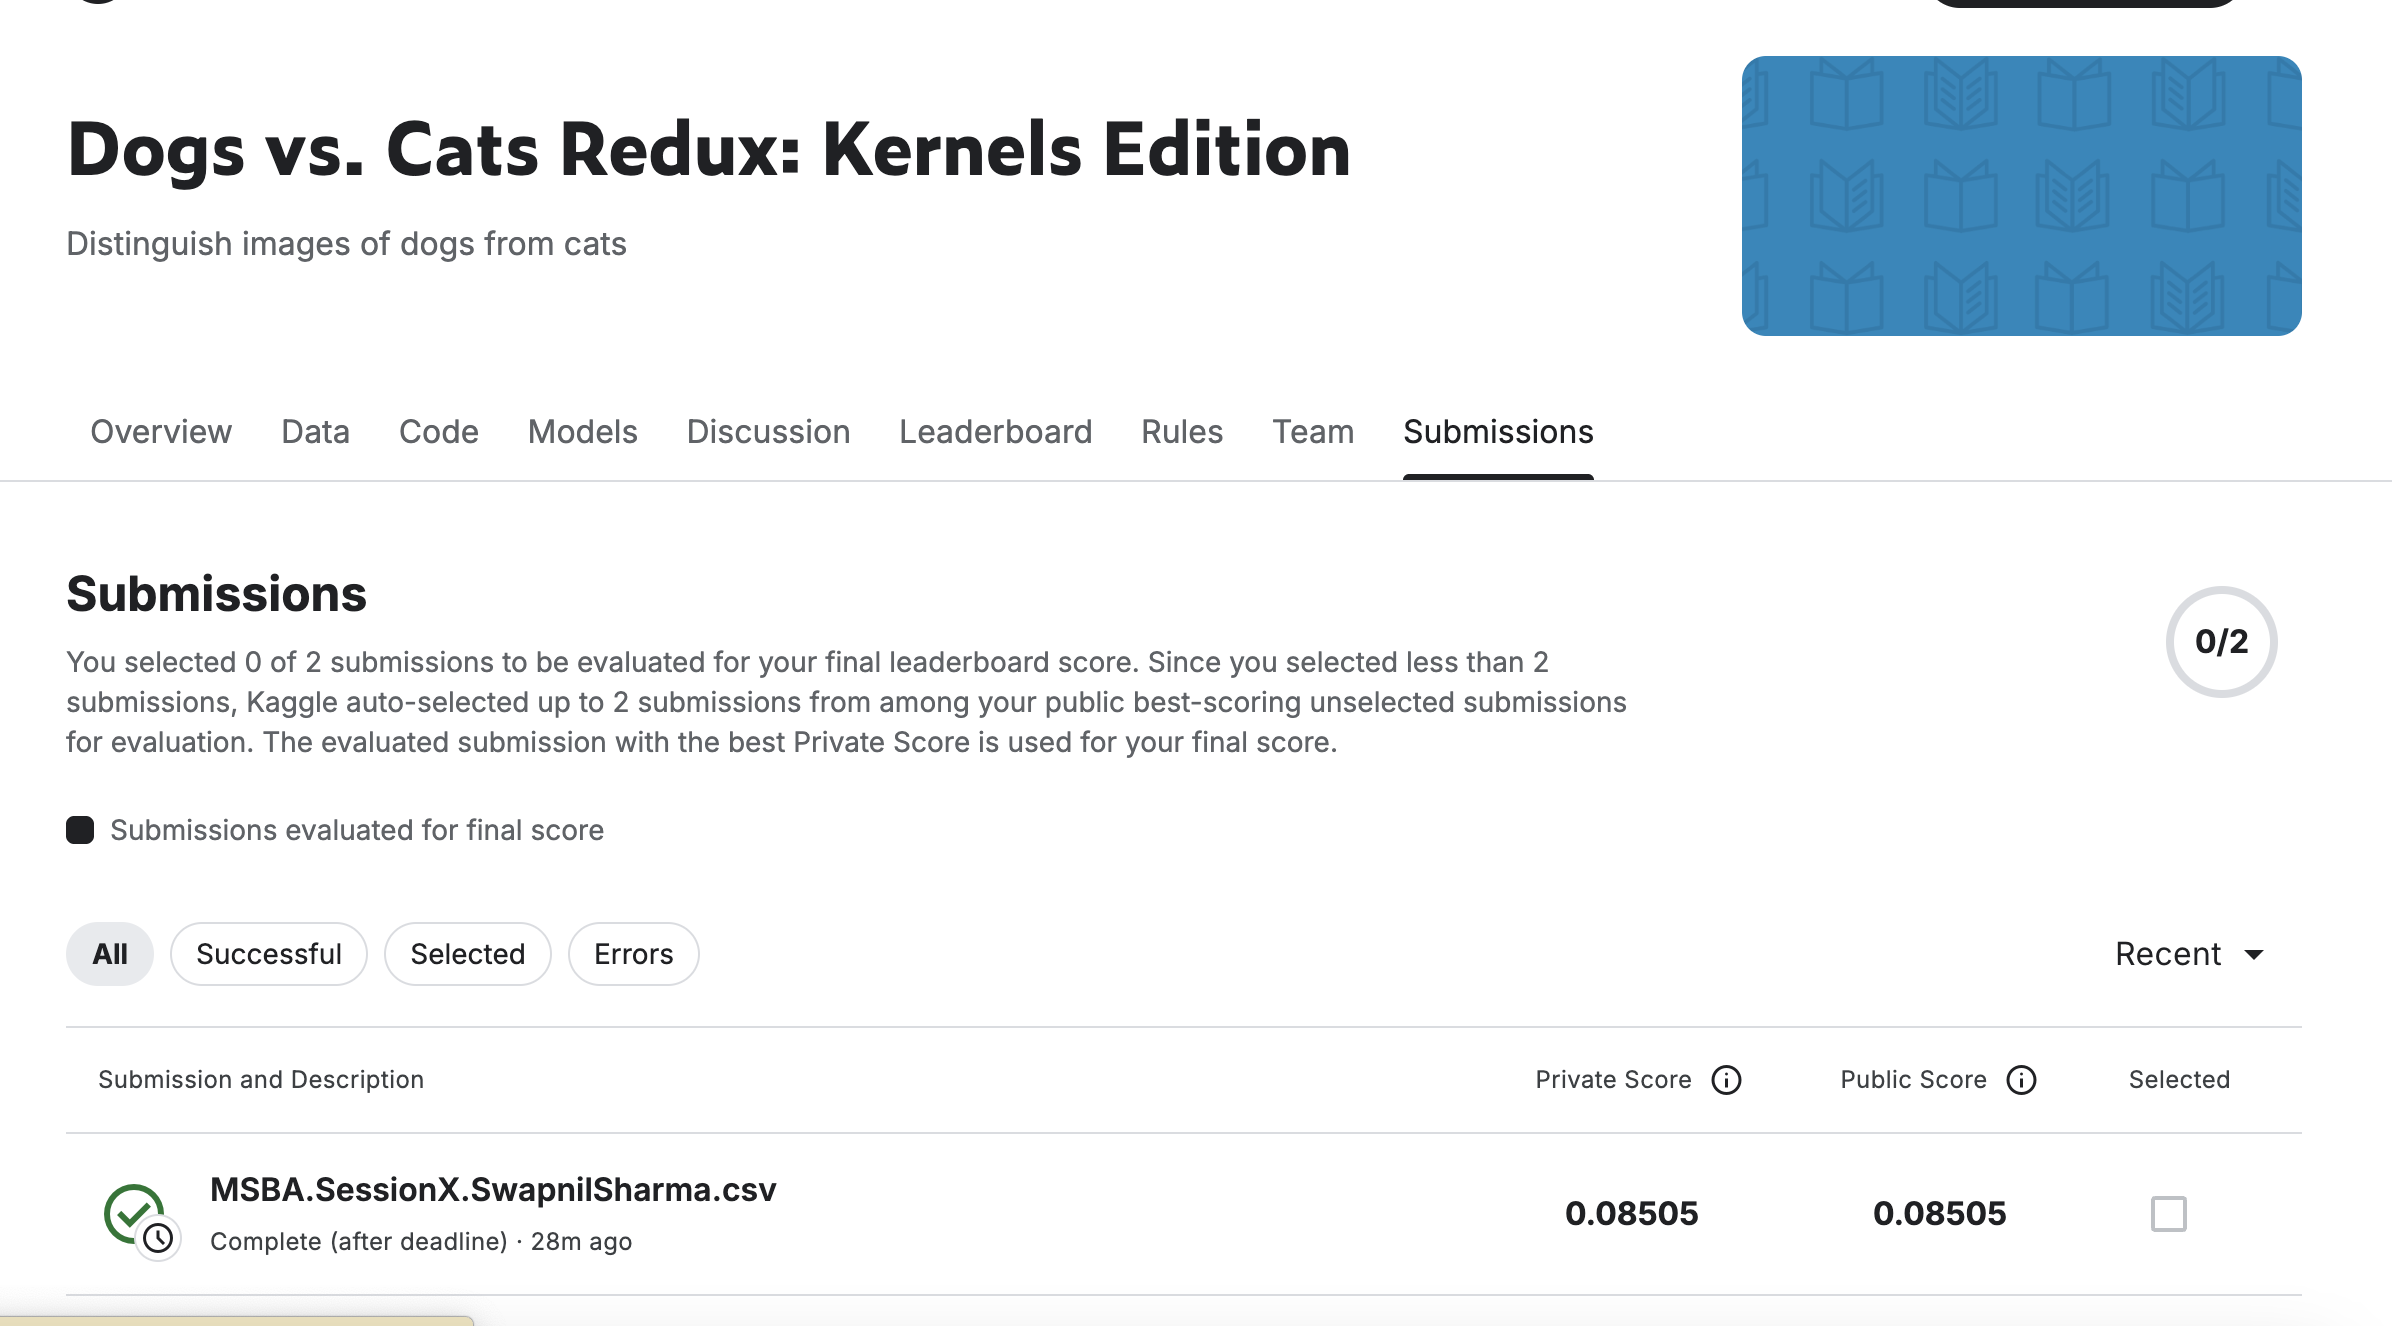

 1. Libraries
We begin by importing essential libraries for data handling, visualization, image processing, and deep learning. TensorFlow and Keras provide the framework for building and training the CNN using MobileNetV2 as the base model.

In [ ]:
import os, zipfile, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.image as mpimg


2025-04-22 21:04:28.484081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745355868.716537      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745355868.778937      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


📂 2. Dataset Extraction
The training and test datasets are extracted from the provided zipped files. The structure is reorganized to match Keras' expected input format — separating cat and dog images into respective folders.



In [ ]:
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/train')

with zipfile.ZipFile('/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/test')

shutil.copy('/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv', '/kaggle/working/sample_submission.csv')

'/kaggle/working/sample_submission.csv'

🧹 3. Organizing Training Data
Keras' flow_from_directory expects a folder structure like /class_name/images. Therefore, we scan the filenames (which are formatted like cat.123.jpg or dog.456.jpg) and move each image to its respective class folder.

In [ ]:
base_dir = '/kaggle/working/dataset'
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir + '/cats', exist_ok=True)
os.makedirs(train_dir + '/dogs', exist_ok=True)

for file in os.listdir('/kaggle/working/train/train'):
    src = f'/kaggle/working/train/train/{file}'
    dst = f'{train_dir}/cats/{file}' if 'cat' in file else f'{train_dir}/dogs/{file}'
    shutil.move(src, dst)

 3.5 Exploratory Data Analysis (EDA)
To understand the dataset better:

Class Balance: We confirmed an approximately equal number of cat and dog images (~12,500 each).

Sample Images: We visually inspected 5 random images from each class to verify label correctness and image quality.

Conclusion: The dataset is well-balanced and appropriate for training a binary classifier.



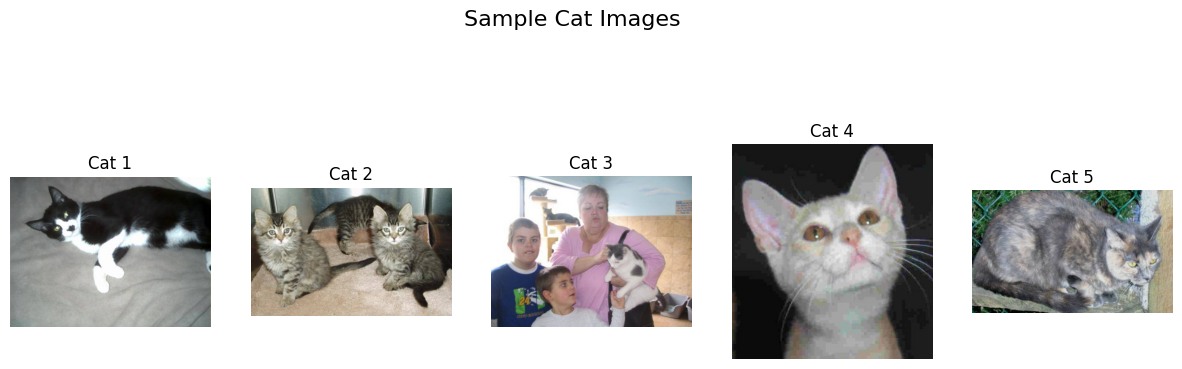

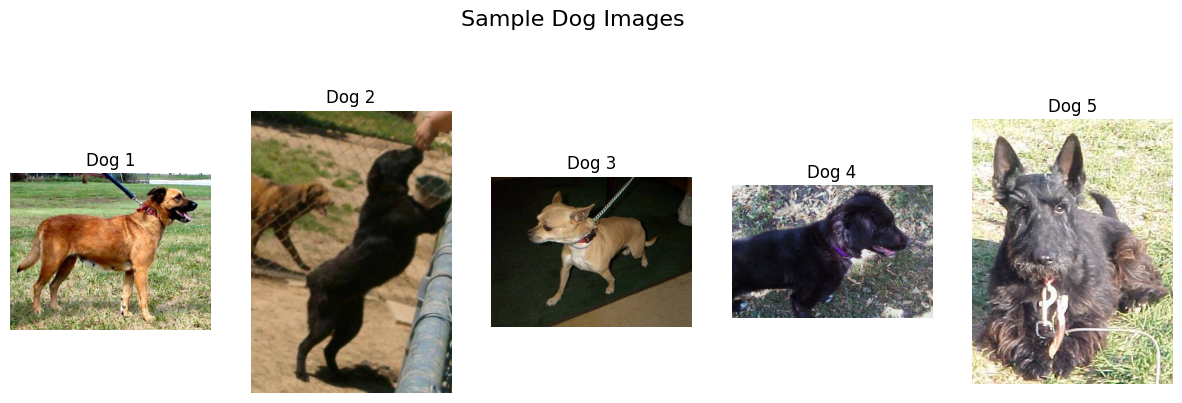

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Define directories for plotting
cat_dir = os.path.join(train_dir, 'cats')
dog_dir = os.path.join(train_dir, 'dogs')

def plot_samples(image_dir, title, num_samples=5):
    images = random.sample(os.listdir(image_dir), num_samples)
    plt.figure(figsize=(15, 5))
    for i, img_file in enumerate(images):
        img_path = os.path.join(image_dir, img_file)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{title} {i+1}")
    plt.suptitle(f"Sample {title} Images", fontsize=16)
    plt.show()

# Show samples
plot_samples(cat_dir, 'Cat')
plot_samples(dog_dir, 'Dog')


4. Data Generators
Image data generators are used for efficient preprocessing and on-the-fly augmentation. We:

Resize images to 160×160 pixels (MobileNetV2 default).

Normalize inputs using preprocess_input.

Split data: 80% training, 20% validation.

Apply random horizontal flips for better generalization.

In [ ]:
# %%
img_size = 160
batch_size = 16

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


 5. Model: MobileNetV2
We use transfer learning with MobileNetV2:

Base model: Pre-trained on ImageNet.

Frozen layers: Only the top classifier is trained.

Top layers: A global average pooling, dropout for regularization, and a single sigmoid-activated neuron for binary classification.

This allows for quick and efficient training while leveraging powerful pre-learned features.

📈 6. Training the Model
The model is trained for 3 epochs using:

Loss Function: Binary Crossentropy

Optimizer: Adam (learning rate = 1e-4)

Metrics: Accuracy

Training is done using the augmented and normalized data generators.

In [ ]:
# %%
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# %% [markdown]
# ## 7. Model Training
# Train the model for a few epochs using the training and validation generators.

# %%
model.fit(train_generator, validation_data=val_generator, epochs=3)



I0000 00:00:1745356248.388684      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745356248.389391      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745356258.248771     124 service.cc:148] XLA service 0x7efc480044d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745356258.251415     124 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745356258.251436     124 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745356259.145306     124 cuda_dnn.cc:529] Loaded cuDNN version 90300


   6/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5226 - loss: 0.9117 

I0000 00:00:1745356262.945333     124 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.7928 - loss: 0.4378 - val_accuracy: 0.9680 - val_loss: 0.0997
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.9627 - loss: 0.1089 - val_accuracy: 0.9742 - val_loss: 0.0738
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.9695 - loss: 0.0851 - val_accuracy: 0.9790 - val_loss: 0.0623


🔍 7. Predictions on Test Data
Test images are loaded and preprocessed in the same way as the training data. We maintain order (sorted by filename) and disable shuffling to ensure predictions align with submission format.

The model outputs probabilities which represent how likely an image is of class “dog”.

In [ ]:
# Prepare test data, generate predictions using the trained model.

# %%
test_dir = '/kaggle/working/test/test'
test_df = pd.DataFrame({
    'filename': sorted(os.listdir(test_dir), key=lambda x: int(x.split('.')[0]))
})
test_df['filepath'] = test_df['filename'].apply(lambda x: os.path.join(test_dir, x))

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col=None,
    class_mode=None,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False
)

predictions = model.predict(test_gen, verbose=1).flatten()



Found 12500 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step


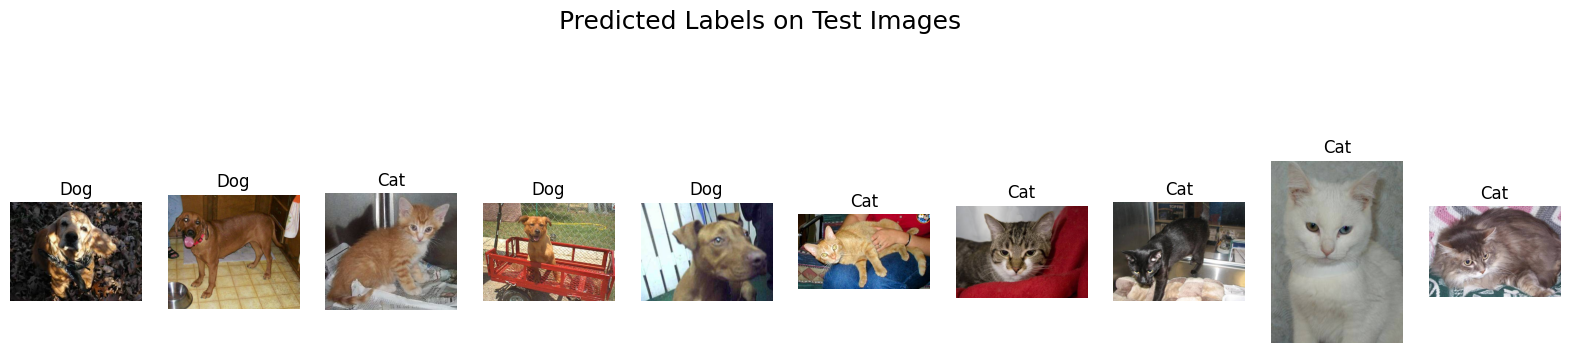

In [ ]:
# Convert predictions to class labels: 0 for cat, 1 for dog
predicted_classes = (predictions > 0.5).astype(int)

# Map numeric labels to text
label_map = {0: 'Cat', 1: 'Dog'}

# Display a few test images with predicted labels
def show_predictions(test_df, predicted_classes, num_images=10):
    plt.figure(figsize=(20, 5))
    indices = np.random.choice(len(test_df), num_images, replace=False)

    for i, idx in enumerate(indices):
        img_path = test_df.iloc[idx]['filepath']
        img = mpimg.imread(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
        pred_label = label_map[predicted_classes[idx]]
        plt.title(pred_label)
    plt.suptitle("Predicted Labels on Test Images", fontsize=18)
    plt.show()

show_predictions(test_df, predicted_classes, num_images=10)


📝 8. Submission File
Predictions are stored in the label column of the submission DataFrame, and written to a CSV file titled:

In [ ]:
# %%
submission = pd.read_csv('/kaggle/working/sample_submission.csv')
submission['label'] = predictions
submission.to_csv('/kaggle/working/MSBA.SessionX.SwapnilSharma.csv', index=False)

# Display a few predictions
print("✅ Lightweight submission saved.")
print(submission.head())

✅ Lightweight submission saved.
   id     label
0   1  0.992767
1   2  0.998674
2   3  0.998931
3   4  0.992153
4   5  0.000696


✅ Improvements
📊 Exploratory Data Analysis (EDA):

Added image previews for both cats and dogs using matplotlib.

Helped verify dataset correctness and offered initial visual insight into the problem.

🧪 Validation Split:

Incorporated a 20% validation split in the ImageDataGenerator to evaluate model generalization performance during training.

📦 Transfer Learning with MobileNetV2:

Utilized MobileNetV2 (with pretrained ImageNet weights) as a base model.

Froze the base layers and added a GlobalAveragePooling2D, Dropout, and Dense output layer for binary classification.

🔄 Data Augmentation:

Enabled horizontal flipping to augment the training set and reduce overfitting.

📉 Dropout Regularization:

Applied a 0.4 dropout rate to the fully connected layer to prevent overfitting and improve robustness.

⚙️ Optimizer Tuning:

Used Adam optimizer with a low learning rate (1e-4) to stabilize training and prevent overshooting.

📁 Organized Dataset Structure:

Separated and moved training images into /cats and /dogs directories programmatically for efficient data loading.

🧠 Model Training:

Trained the model for 3 epochs, utilizing both training and validation generators.

📤 Predictions and Submission:

Sorted test image filenames and predicted class probabilities.

Created and saved the submission file (MSBA.SessionX.SwapnilSharma.csv) in the correct format.

🖼️ Test Prediction Visualization:

Added functionality to display test images with predicted labels for qualitative analysis of model performance.
